# Submission for IT-Talents.de Code Competition 09/2018 in Cooperation with ZF 
Author: Benedkt Christoph Wolters 

E-Mail: mail@benedikt-wolters.de / https://www.benedikt-wolters.de


# Introduction

We chose to first analyze and clean the data according to observed values. 
Subsequently, we group records by similiarity and  derive features from the cleaned values.
Ultimately, we develop a deep-learning model using our extracted features splitting the dataset into training and validation data.

Our final model is comprised of a feed-forward neural net with embeddings for categorical values, multiple linear-layers and dropout layers.
The end-result has an accuraccy of 82% on the validation set.


# Preliminaries & Loading
This section only contains import and takes care of loading the taining and final data

In [221]:
#This notebook requires torch, pandas, numpy, pandas and  matplotlib to be installed, locally.
%matplotlib inline
%store
%load_ext autoreload
%autoreload 2

import copy
from collections import Counter 
import matplotlib.pyplot as plt
import logging
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.exceptions import DataConversionWarning
from sklearn_pandas import DataFrameMapper #https://github.com/scikit-learn-contrib/sklearn-pandas
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from pandas_summary import DataFrameSummary # https://github.com/mouradmourafiq/pandas-summary
import warnings


Stored variables and their in-db values:
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
def load_dataset(filename):
    """ Helper function to load the CSV-files attached to this challenge
        
        Percularities:
        - Use the correct encoding format for Umlauts.
        - Tell pandas that `Zeit (24h)` is a string rather than a number (for better processing later)
        - Name unnamed index column `DataSet_Idx`
    """
    
    return  pd.read_csv(filename,encoding='ISO-8859-1',dtype={'Zeit (24h)':str}).rename( columns={'Unnamed: 0':'DataSet_Idx'})

In [223]:
training_set = load_dataset('./data/verkehrsunfaelle_train.csv')
test_set = load_dataset('./data/verkehrsunfaelle_test.csv')
TARGET_FEATURE='Unfallschwere'

# Data Exploration / Cleaning

## Exploration and Sanity Checking

Let's start by having a look at the given Data first. For ease of data-exploration lets merge the given datasets first to get a better impression what kind of data we are dealing with.


In [224]:
merged = pd.concat([training_set,test_set],sort=True,ignore_index=True)
#classify if data was part of the test set or not, not test data has no 'Unfallschwere'-Field, so it will be na()
merged['is_test'] = merged[TARGET_FEATURE].isna()

# Smoketesting: Check if somethin got dropped, numbers add up
lenTraining = !cat ./data/verkehrsunfaelle_train.csv | wc -l 
lenTest = !cat ./data/verkehrsunfaelle_test.csv | wc -l 

# Print out some numbers to do a quick-sanity check:
display((int(lenTraining[0])-1, len(training_set), int(lenTest[0])-1, len(test_set),len(merged),len(training_set.columns), len(test_set.columns)))
display("Columns: ", len(merged.columns), merged.columns.values)

(15221, 15221, 1000, 1000, 16221, 14, 13)

'Columns: '

15

array(['Alter', 'Anzahl Fahrzeuge', 'Bodenbeschaffenheit', 'DataSet_Idx',
       'Fahrzeugtyp', 'Geschlecht', 'Lichtverhältnisse', 'Strassenklasse',
       'Unfalldatum', 'Unfallklasse', 'Unfallschwere',
       'Verletzte Personen', 'Wetterlage', 'Zeit (24h)', 'is_test'],
      dtype=object)

# Is there univariate dependency?
Let's first determine whether there is a low-hanging fruit or obvious relationship between our Target Feature (Unfallschwere and the involved types of cars, types of roads or the amount of involved people)

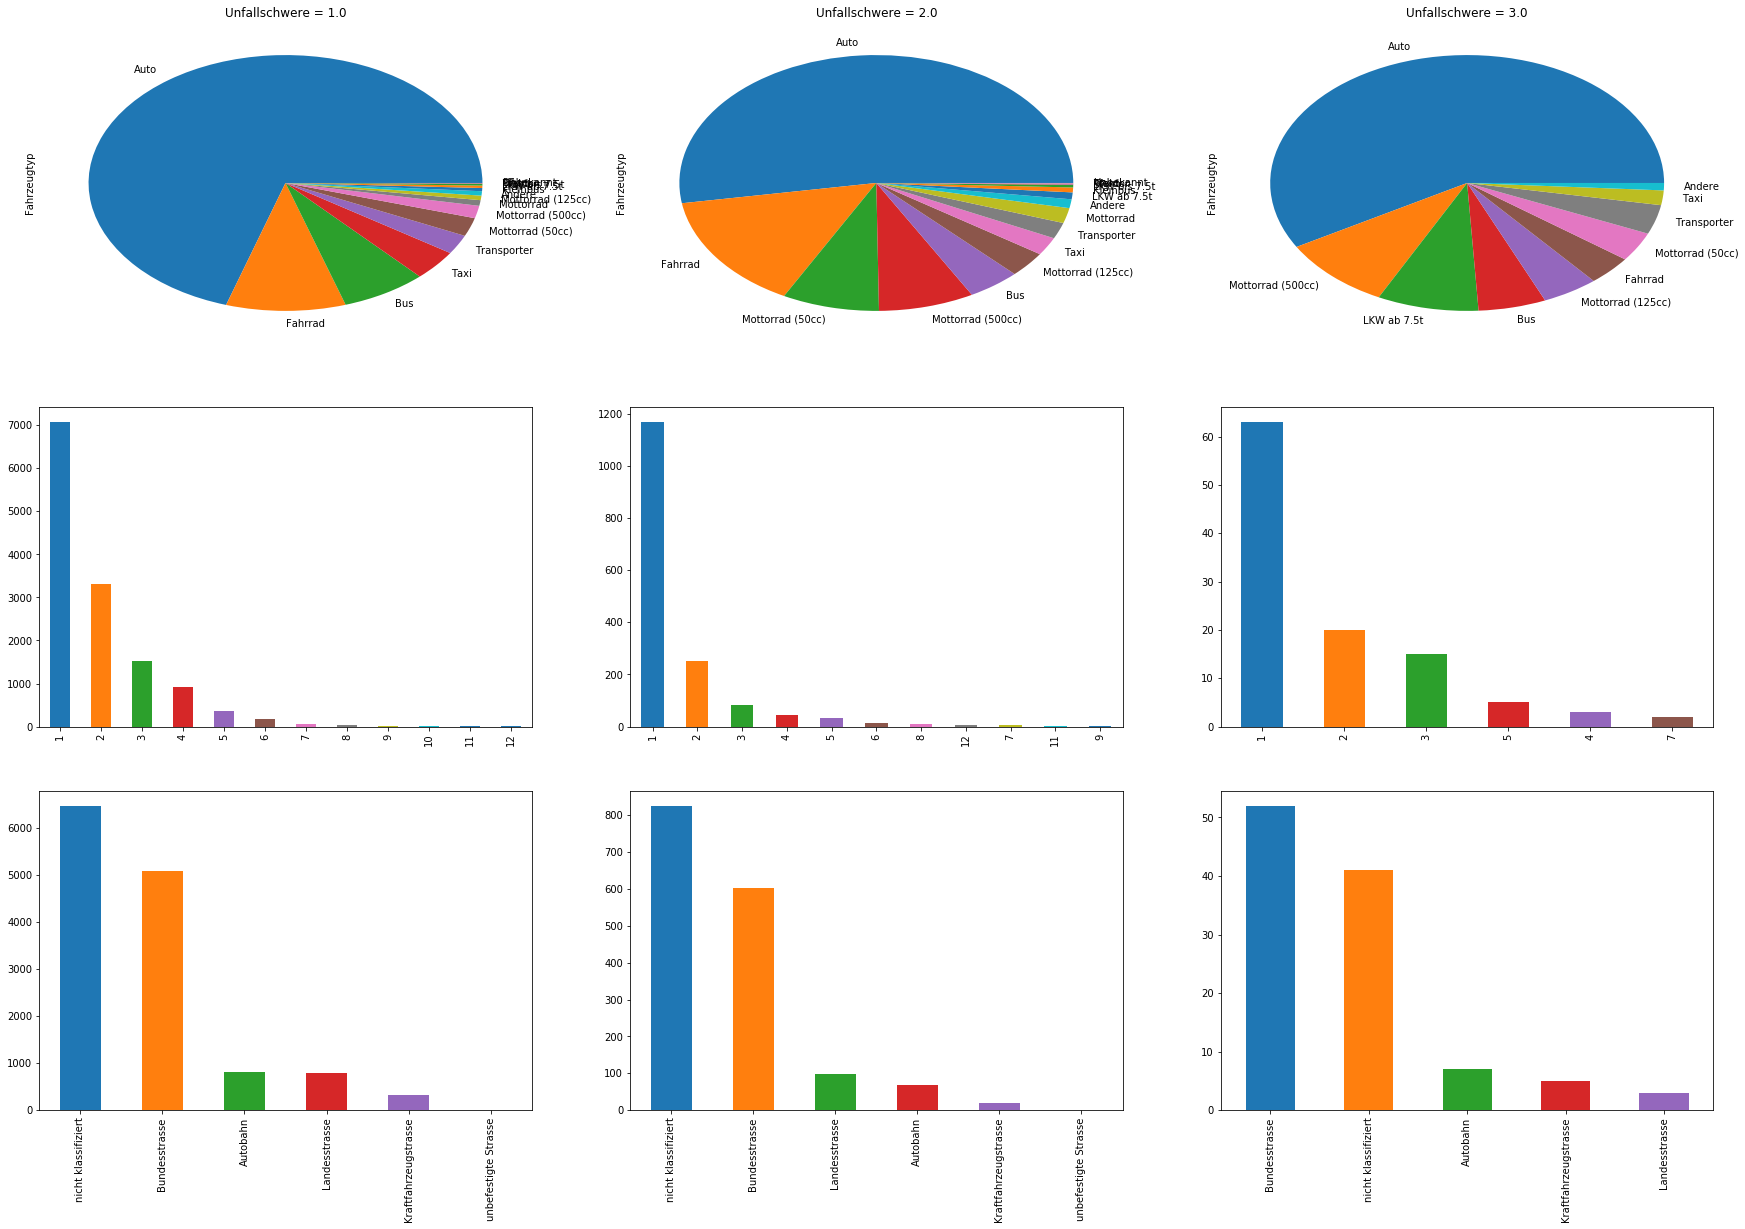

In [225]:

unfallschwere_types = merged[TARGET_FEATURE].dropna().unique()
fields=['Fahrzeugtyp','Verletzte Personen', 'Strassenklasse']
fig, ax = plt.subplots(nrows=len(fields),ncols=len(unfallschwere_types))
fig.set_size_inches(len(fields)*10,20)
for i, x in enumerate(unfallschwere_types):
    ax[0][i].set_title(TARGET_FEATURE+" = {}".format(x))
    for j, field in enumerate(fields):
        if j == 0:
            ptype='pie'
        else:
            ptype='bar'
        merged[merged[TARGET_FEATURE] == x][field].value_counts().plot(kind=ptype,ax=ax[j][i])


From the first look there is nothing obvious, that stands out!

## Cleaning Feature Fields

In this section we are going to preprocess the data in order to make the data more homogenous and easier for our deep learning model to process.
Moreover, this will also aid our process of deriving features leater on.


In [226]:
# What kind of values can we expect?
merged.head(n=10)

,Alter,Anzahl Fahrzeuge,Bodenbeschaffenheit,DataSet_Idx,Fahrzeugtyp,Geschlecht,Lichtverhältnisse,Strassenklasse,Unfalldatum,Unfallklasse,Unfallschwere,Verletzte Personen,Wetterlage,Zeit (24h),is_test
0,59,2,trocken,0,LKW ab 7.5t,männlich,Tageslicht: Strassenbeleuchtung vorhanden,Bundesstrasse,23. Jan.,Fahrer,1.0,2,Gut,1330,False
1,48,4,trocken,1,Auto,weiblich,Tageslicht: Strassenbeleuchtung vorhanden,Autobahn,17-May-11,Fahrer,1.0,2,Gut,1724,False
2,56,1,nass / feucht,2,Mottorrad (500cc),männlich,Tageslicht: Strassenbeleuchtung vorhanden,nicht klassifiziert,14. Feb.,Fahrer,2.0,1,Gut,1345,False
3,66,2,nass / feucht,3,Auto,weiblich,Dunkelheit: Strassenbeleuchtung vorhanden und ...,Bundesstrasse,31-Oct-12,Fahrer,1.0,3,Regen,1830,False
4,33,1,nass / feucht,4,Auto,männlich,Dunkelheit: keine Strassenbeleuchtung,Bundesstrasse,3. Nov.,Fahrer,2.0,1,Gut,15,False
5,72,2,trocken,5,Auto,weiblich,Tageslicht: Strassenbeleuchtung vorhanden,nicht klassifiziert,31-May-09,Passagier,1.0,4,Gut,1457,False
6,62,2,trocken,6,Fahrrad,männlich,Tageslicht: Strassenbeleuchtung vorhanden,Bundesstrasse,24. Okt.,Fahrer,1.0,1,Gut,1130,False
7,45,2,trocken,7,Transporter,männlich,Tageslicht: Strassenbeleuchtung vorhanden,nicht klassifiziert,25. Jul.,Fahrer,1.0,2,Gut,1520,False
8,66,2,Schnee,8,Auto,weiblich,Tageslicht: Strassenbeleuchtung vorhanden,Bundesstrasse,7. Jan.,Passagier,2.0,2,Schnee,1057,False
9,67,3,trocken,9,Auto,weiblich,Tageslicht: Strassenbeleuchtung vorhanden,Bundesstrasse,10. Sep.,Fahrer,1.0,2,Gut,1300,False


In [227]:
#Let's define two sets of features we are going to incorporate into our model.
categorical_to_use = set() #categorical variables (e.g., Bodenbeschaffenheit, Geschlecht, ...)
continuous_to_use = set() # numerical variables, (e.g., Alter)


In the following we will iterate over all the fields and see what we need to clean
### A Deeper Look at `Unfalldatum`

Date fields are one of the most valuable data sources for predictive models as they can contain much more than just a timestamp and allow correlation to other datasets.
Unfalldatum has various formats from different types (from differnet localizations). We unify it by appending a sentinel date (`2028` = leap-year) in the future and converting it to a pandas datetime object.

In [228]:
def clean_unfalldatum(datum):
    YEAR_TO_APPEND = '2028' #Training dataset contains Feb 29th, so missing values must be a leap-year, use canary value of 2028 here to distinguish
    import locale
    import datetime 
        
    #Date values are given in a Mixture of English/German months locale, i.e.: Okt. instead of Oct.
    datum = datum.replace('Mrz.','Mar.')
    datum = datum.replace('Okt.','Oct.')
    datum = datum.replace('Dez.','Dec.')
    datum = datum.replace('Mai.','May.')
    
    dt = pd.to_datetime(datum,format='%d-%b-%y',errors='coerce')
    if dt is not pd.NaT:
        return dt
    dt = pd.to_datetime(datum+YEAR_TO_APPEND,format='%d. %b.%Y',errors='coerce')
    
    
    """ Old code, problem: relies on locale de_DE being installed, which is a problem on some cloud-computing platforms such as google-colab.
    datum = datum.replace('Mrz.','Mär.')
    
    #Ensure you have German Locale installed, on Ubuntu 18.04 it's: 
    #!sudo locale-gen de_DE
    #!sudo locale-gen de_DE.UTF8
    #!sudo update-locale && sudo dpkg update-locales
    
    
    locale.setlocale(locale.LC_ALL, 'de_DE')
    dt = pd.to_datetime(datum+append_year,format='%d. %b.%Y',errors='coerce')
    # If year is not present, we assume its this year
    if dt is pd.NaT:
        dt = pd.to_datetime(datum,format='%d-%b-%y',errors='coerce')
    
    #Fall back to parsing English dates
    if dt is pd.NaT:
        dt = pd.to_datetime(datum+append_year,format='%d. %b.%Y',errors='coerce')
        # If year is not present, we assume its this year        
        locale.setlocale(locale.LC_ALL, 'en_GB')
        if dt is pd.NaT:
            dt = pd.to_datetime(datum,format='%d-%b-%y',errors='coerce')
    
    return dt
    """
    
    if dt is pd.NaT:
        print(datum)
        dt = pd.NaT
    
    return dt

# Apply our cleaning function
merged['cleaned_unfalldatum'] =  merged['Unfalldatum'].apply(clean_unfalldatum)

In [229]:
#Was that successful?
display(len(merged['cleaned_unfalldatum'][merged['cleaned_unfalldatum'] == pd.NaT]))

0

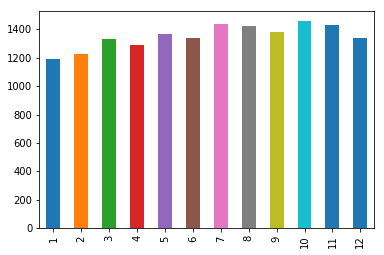

In [230]:
#Lets separate month from the Date and also plot if the data is skewed over different months...
merged['cleaned_month'] = merged['cleaned_unfalldatum'].apply(lambda x:x.month)
vc = merged['cleaned_month'].value_counts()
vc.sort_index().plot(kind='bar')
categorical_to_use.add('cleaned_month')

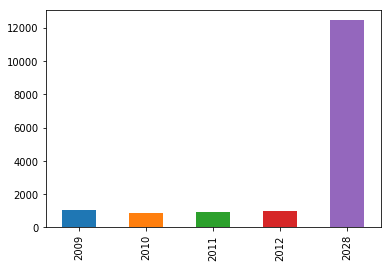

In [231]:
#Same for year
merged['cleaned_year'] = merged['cleaned_unfalldatum'].apply(lambda x:x.year)
vc = merged['cleaned_year'].value_counts()
vc.sort_index().plot(kind='bar')
categorical_to_use.add('cleaned_year')


Note that a lot of values have no year (2028),
that means adding features such as "Day of the Week", "Was it a holiday?" and augmenting Data from other Data-sources will be very difficult later-on, because we do not know the exact date, but only the day/month.

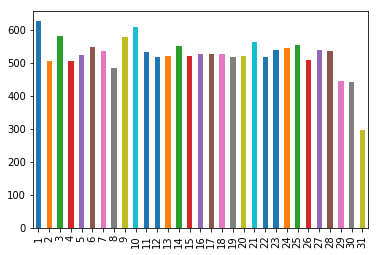

In [232]:
#Same for Day of month. Tail-end is obviously fewer due to February
merged['cleaned_day'] = merged['cleaned_unfalldatum'].apply(lambda x:x.day)
vc = merged['cleaned_day'].value_counts()
vc.sort_index().plot(kind='bar')
categorical_to_use.add('cleaned_day')

## Categorical Fields, Data Cleaning
Let's inspect the other fields, especially the categorical values that are in the datafield, such that we know which fields we need to clean up further

Index(['DataSet_Idx', 'Strassenklasse', 'Unfalldatum', 'Alter', 'Unfallklasse',
       'Unfallschwere', 'Lichtverhältnisse', 'Verletzte Personen',
       'Anzahl Fahrzeuge', 'Bodenbeschaffenheit', 'Geschlecht', 'Zeit (24h)',
       'Fahrzeugtyp', 'Wetterlage'],
      dtype='object')

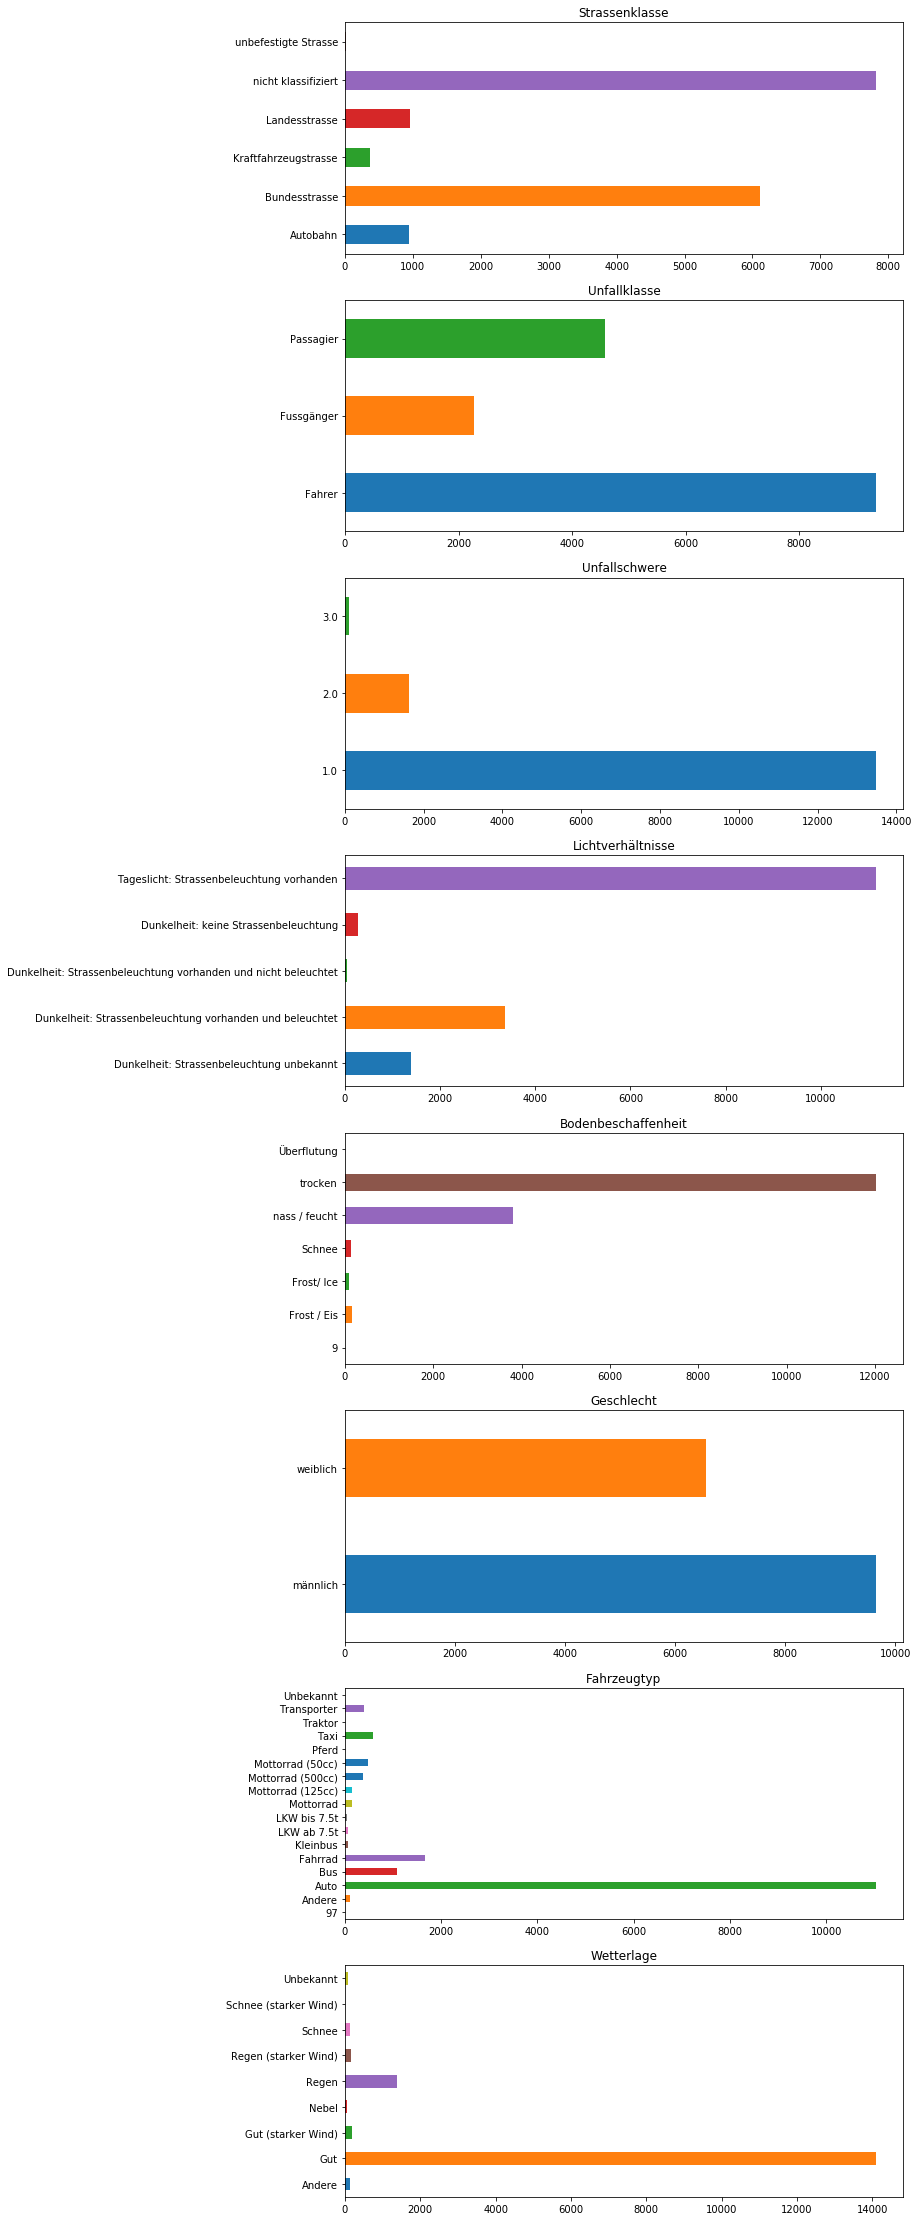

In [233]:
display(training_set.columns)
categorical = ['Strassenklasse','Unfallklasse', 'Unfallschwere', 'Lichtverhältnisse','Bodenbeschaffenheit','Geschlecht', 'Fahrzeugtyp', 'Wetterlage']
continuious = ['Alter', 'Verletzte Personen', 'Anzahl Fahrzeuge', 'Zeit (24h)']
fig, ax = plt.subplots(nrows=len(categorical),ncols=1,)
fig.set_size_inches(w=10,h=40)
for i, column in enumerate(categorical):
    vc = merged[column].value_counts()
    ax[i].set_title(column)
    vc.sort_index().plot(kind='barh',ax=ax[i])



Observations from plots above:
 - We can use `Geschlecht`, `Unfallklasse`, `Strassenklasse` pretty much without further cleaing
 - We must clean `Wetterlage` as it sometimes contains information about wind and sometimes not.
 - We must clean `Fahrzeugtyp` (various features within same field)
 - We must clean `Bodenbeschaffenheit` (duplicates with same names)
 - We must clean `Lichtverhaeltnisse` (multiple features within same field.
 - There is a huge disparity between fields that have been classified as 1.0 and 2.0 and 3.0 (2.0 and 3.0 are much less frequent)
                                        

In [234]:
#Geschlecht
merged['cleaned_geschlecht'] = merged['Geschlecht']
categorical_to_use.add('cleaned_geschlecht')

In [235]:
#Unfallklasse
merged['cleaned_unfallklasse'] = merged['Unfallklasse']
categorical_to_use.add('cleaned_unfallklasse')

In [236]:
#Strassenkasse
merged['cleaned_strassenklasse'] = merged['Strassenklasse']
categorical_to_use.add('cleaned_strassenklasse')

In [237]:
#Normalize Wetterlage
#Split that into two Fields (`Wind` + actual `Wetterlage`)
#Extract Starker Wind
def hasWind(x):
    if "starker Wind" in x:
        return True
    else:
        return False
    
merged['cleaned_wind'] = merged['Wetterlage'].apply(hasWind)
merged['cleaned_wind'].value_counts()
categorical_to_use.add('cleaned_wind')

def cleanWetterlage(x):
    x = x.replace(' (starker Wind)','')
    x = x.replace('Andere',"Unbekannt")
    return x

#Normalize Wetterlage
merged['cleaned_wetterlage'] = merged['Wetterlage'].apply(cleanWetterlage)
merged['cleaned_wetterlage'].value_counts()
categorical_to_use.add('cleaned_wetterlage')

In [238]:
def normalizeFahrzeugtyp(x):
    if "Mottorrad" in x: 
        return "Motorrad" # Ignore cc + fix spelling...
    if "LKW" in x:
        return x
    if x in ('Auto','Fahrrad','Bus','Taxi','Kleinbus','Transporter','Pferd','Traktor','Unbekannt'):
        return x
    return "Andere" #Note: we differentiate between `Unbekannt` and `Andere` as their semantics might be somewhat different 

merged['cleaned_fahrzeugtyp'] = merged['Fahrzeugtyp'].apply(normalizeFahrzeugtyp)
display(merged['Fahrzeugtyp'].value_counts())
display(merged['cleaned_fahrzeugtyp'].value_counts())

#If it is a bike, extract CC to an extra feature
def normalizeCC(x):
    if "Mottorrad" in x and 'cc' in x: 
        if "50cc" in x:
            return '50'
        if "125cc" in x:
            return '125'
        if '500cc' in x:
            return '500'
    return "Unbekannt"
merged['cleaned_cc'] = merged['Fahrzeugtyp'].apply(normalizeCC)
display(merged['cleaned_cc'].value_counts())
categorical_to_use.add('cleaned_fahrzeugtyp')
categorical_to_use.add('cleaned_cc')


#Let's derive a new binary-feature that tell's us if it is a two-wheel vehicle as well
def isZweirad(x):
    if "Mottorrad" in x or "Fahrrad" in x: 
        return True
    return False
merged['cleaned_zweirad'] = merged['Fahrzeugtyp'].apply(isZweirad)
display(merged['cleaned_zweirad'].value_counts())
categorical_to_use.add('cleaned_zweirad')

Auto                 11044
Fahrrad               1664
Bus                   1087
Taxi                   592
Mottorrad (50cc)       477
Transporter            402
Mottorrad (500cc)      376
Mottorrad (125cc)      143
Mottorrad              141
Andere                 100
Kleinbus                71
LKW ab 7.5t             66
LKW bis 7.5t            39
Pferd                    6
Traktor                  6
Unbekannt                4
97                       3
Name: Fahrzeugtyp, dtype: int64

Auto            11044
Fahrrad          1664
Motorrad         1137
Bus              1087
Taxi              592
Transporter       402
Andere            103
Kleinbus           71
LKW ab 7.5t        66
LKW bis 7.5t       39
Pferd               6
Traktor             6
Unbekannt           4
Name: cleaned_fahrzeugtyp, dtype: int64

Unbekannt    15225
50             477
500            376
125            143
Name: cleaned_cc, dtype: int64

False    13420
True      2801
Name: cleaned_zweirad, dtype: int64

In [239]:
#Normalize Bodenbeschaffenheit
def cleanBodenbeschaffenheit(x):
    if "Frost" in x:
        return "Frost"
    if x not in ('trocken','nass / feucht','Frost','Schnee','Überflutung'):
        return 'unbekannt'
    else:
        return x

merged['cleaned_bodenbeschaffenheit'] = merged['Bodenbeschaffenheit'].apply(cleanBodenbeschaffenheit)
display(merged['cleaned_bodenbeschaffenheit'].value_counts())

categorical_to_use.add('cleaned_bodenbeschaffenheit')

trocken          12034
nass / feucht     3797
Frost              245
Schnee             132
Überflutung         12
unbekannt            1
Name: cleaned_bodenbeschaffenheit, dtype: int64

In [240]:
#Normalize Lichtverhaeltnisse
#Contains multiple values...
def cleanLichtverhaeltnisse(x):
    if "Tageslicht" in x:
        return "Tageslicht"
    elif "Dunkelheit" in x:
        return "Dunkelheit"
    else:
        return "Unknown"
    return x

def getBeleuchtung(x):
    if "Tageslicht" in x:
        return "tageslicht"
    if "nicht beleuchtet" in x or "keine Strassenbeleuchtung" in x:
        return "unbeleuchtet"
    elif  "beleuchtet" in x:
        return "beleuchtet"
    else:
        return "unbekannt"

def hasBeleuchtung(x):
    if "Strassenbeleuchtung vorhanden" in x:
        return "vorhanden"
    if "keine Strassenbeleuchtung" in x:
        return "nicht vorhanden"
    else:
        return "unbekannt"
#Normalize Wetterlage
merged['cleaned_lichtverhaeltnisse'] = merged['Lichtverhältnisse'].apply(cleanLichtverhaeltnisse)
merged['cleaned_beleuchtung'] = merged['Lichtverhältnisse'].apply(getBeleuchtung)
merged['cleaned_beleuchtung_vorhanden'] = merged['Lichtverhältnisse'].apply(hasBeleuchtung)
display(merged['cleaned_lichtverhaeltnisse'].value_counts())
display(merged['Lichtverhältnisse'].value_counts())
display(merged['cleaned_beleuchtung'].value_counts())
display(merged['cleaned_beleuchtung_vorhanden'].value_counts())
categorical_to_use.add('cleaned_lichtverhaeltnisse')
categorical_to_use.add('cleaned_beleuchtung')
categorical_to_use.add('cleaned_beleuchtung_vorhanden')



Tageslicht    11171
Dunkelheit     5050
Name: cleaned_lichtverhaeltnisse, dtype: int64

Tageslicht: Strassenbeleuchtung vorhanden                         11171
Dunkelheit: Strassenbeleuchtung vorhanden und beleuchtet           3354
Dunkelheit: Strassenbeleuchtung unbekannt                          1379
Dunkelheit: keine Strassenbeleuchtung                               281
Dunkelheit: Strassenbeleuchtung vorhanden und nicht beleuchtet       36
Name: Lichtverhältnisse, dtype: int64

tageslicht      11171
beleuchtet       3354
unbekannt        1379
unbeleuchtet      317
Name: cleaned_beleuchtung, dtype: int64

vorhanden          14561
unbekannt           1379
nicht vorhanden      281
Name: cleaned_beleuchtung_vorhanden, dtype: int64

## Continous Variables
Up until now we looked at categorical data. However, our dataset also contains _some_ continous variables namely `Verletzte Personen` and `Anzahl Fahrzeuge`

In [241]:
continuous_to_use.add('Verletzte Personen')
continuous_to_use.add('Anzahl Fahrzeuge')

In [242]:
for var in continuous_to_use:
    # Check if we have missing values etc. that require further steps..
    display(var, merged[var].dtype, len(merged[merged[var].isna()]))


'Anzahl Fahrzeuge'

dtype('int64')

0

'Verletzte Personen'

dtype('int64')

0

That means we are good to go for this values.

## Summary

Let's have a quick overview whether we missed something.

In [243]:
#merged.drop('Unfallschwere',inplace=True,axis=1)
dfs = DataFrameSummary(merged[merged['is_test']==False])
dfs.columns_stats.T

,counts,uniques,missing,missing_perc,types
Alter,15221,98,0,0%,numeric
Anzahl Fahrzeuge,15221,11,0,0%,numeric
Bodenbeschaffenheit,15221,7,0,0%,categorical
DataSet_Idx,15221,15221,0,0%,numeric
Fahrzeugtyp,15221,17,0,0%,categorical
Geschlecht,15221,2,0,0%,bool
Lichtverhältnisse,15221,5,0,0%,categorical
Strassenklasse,15221,6,0,0%,categorical
Unfalldatum,15221,850,0,0%,categorical
Unfallklasse,15221,3,0,0%,categorical


# Feature Engineering

Previously, we only looked at each row individually. However, it might be that there is intra-row correlation between records, e.g. we check if we can find records in our dataset that have the same characteristics, .e.g. the same time, the same dat the same kind of similiarities. If so we can extract more features about the type of crash, e.g. types of involved persons or types of involved vehicles...

In [244]:
# We consider two records in our dataset belonging to the same crash if they share those same values:
GROUP_RECORDS_BY = ['Zeit (24h)',
            'cleaned_month',
            'cleaned_year',
            'cleaned_day',
            'Verletzte Personen',
            'Anzahl Fahrzeuge',
            'cleaned_strassenklasse',
            'cleaned_lichtverhaeltnisse',
            'cleaned_bodenbeschaffenheit',
            'cleaned_wetterlage',
            'cleaned_beleuchtung',
            'cleaned_beleuchtung_vorhanden',
           ]

In [245]:
# Lets give each record a "group-key", i.e. an uniq id of the crash... 
merged['groupkey'] = 0


def regroup(merged,group_by,length_source_of_truth='Verletzte Personen'):
    """
    Note: This will take a while to run N**2!
    
    - Groups dataset by group_by clause,
    - Iterates over identified groups and assigns a uniq group-key
    - If the group is bigger than expected (key: length_source_of_truth='Verletzte Personen'), split the group in half (works for all observed records)
    
    Note: This is a coarse approximation for groups that have more 
    """
    idx= {}
    grouped = merged.groupby(group_by)
    total = 0
    low_mismatches = 0
    group_idx = 0
    for i, group in enumerate(grouped):
        total +=1 
        group_idx+=1
        group_ok=True
        for row,data in group[1].iterrows():
            if data['Verletzte Personen'] < len(group[1]):
                group_ok=False
                low_mismatches+=1

        expected_groupsize = group[1][length_source_of_truth].values[0]
        j = 0 #intra group index
        for row,data in group[1].iterrows():
            if group_ok:
                # Good-case: We found the exact number of "Verletzte Personen" in the group!
                idx[row]=group_idx
                data['groupkey']= group_idx
            else:
                # Bad-case: we grouped to much, we have to split the group at its expected groupsize
                # RISK: This may introduce a classification error
                j = j + 1
                if j == expected_groupsize:
                    j = 0
                    group_idx += 1
                idx[row]=group_idx    
                data['groupkey']= group_idx
    
    display(low_mismatches,total,group_idx,len(merged))
    return grouped,idx

training_idx_merged,idxtraining = regroup(merged[merged['is_test']==False],GROUP_RECORDS_BY)
test_idx_merged,idxtest = regroup(merged[merged['is_test']==True],GROUP_RECORDS_BY)
idxtraining.update(idxtest) #different idx for training and classification set
merged['groupkey'] = [x[0] for x in sorted(zip(list(idxtraining.values()),list(idxtraining.keys())),key=lambda x:x[1])]

60

11165

11217

15221

0

969

969

1000

Having a grouped records, we can now derive additional features
- How big was the group size?
- What was the Min/Max/Average Age?
- Which kind of vehicles were involved?
- Which kind of people were involved and what is their distribution?

In [246]:
#Running this will take a long time, as it examines each group and updates dataframe accordingly (lots of cache misses)
grouped = merged.groupby('groupkey')

def create_intra_group_features(group):
    group_features = {}
    group_features['feature_group_size'] = len(group[1])
    
    group_features['feature_average_age'] = group[1]['Alter'].mean()
    group_features['feature_min_age'] = group[1]['Alter'].min()
    group_features['feature_max_age'] = group[1]['Alter'].max()
    
    
    group_features['feature_anzahl_small_lkw_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'LKW bis 7.5t']) 
    group_features['feature_anzahl_big_lkw_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'LKW ab 7.5t'])
    group_features['feature_anzahl_Taxi_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Taxi'])
    group_features['feature_anzahl_Bus_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Bus'])
    group_features['feature_anzahl_Fahrrad_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Fahrrad'])
    group_features['feature_anzahl_Transporter_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Transporter']) 
    group_features['feature_anzahl_Motorrad_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Motorrad']) 
    group_features['feature_anzahl_Kleinbus_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Kleinbus']) 
    group_features['feature_anzahl_Unbekannt_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Unbekannt']) 


    group_features['cfeature_small_lkw_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'LKW bis 7.5t']) > 0
    group_features['cfeature_big_lkw_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'LKW ab 7.5t']) > 0
    group_features['cfeature_Taxi_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Taxi']) > 0
    group_features['cfeature_Bus_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Bus']) > 0
    group_features['cfeature_Fahrrad_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Fahrrad']) > 0
    group_features['cfeature_Transporter_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Transporter']) > 0
    group_features['cfeature_Motorrad_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Motorrad']) > 0
    group_features['cfeature_Kleinbus_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Kleinbus']) > 0
    group_features['cfeature_Unbekannt_beteiligt'] = len(group[1][group[1]['cleaned_fahrzeugtyp'] == 'Unbekannt']) > 0
    
    group_features['cfeature_Senioren_beteiligt'] = len(group[1][group[1]['Alter'] >= 65]) > 0
    group_features['cfeature_Kinder_beteiligt'] = len(group[1][group[1]['Alter'] <= 12]) > 0
    group_features['cfeature_Fahranfaenger_beteiligt'] = len(group[1][(group[1]['Unfallklasse'] == 'Fahrer') & (group[1]['Alter'] >= 17) & (group[1]['Alter'] <= 26)]) > 0
    group_features['cfeature_Seniorfahrer_beteiligt'] = len(group[1][(group[1]['Unfallklasse'] == 'Fahrer') & (group[1]['Alter'] >= 65)]) > 0
    
    group_features['feature_anzahl_Senioren_beteiligt'] = len(group[1][group[1]['Alter'] >= 65])
    group_features['feature_anzahl_Kinder_beteiligt'] = len(group[1][group[1]['Alter'] <= 12])
    group_features['feature_anzahl_Fahranfaenger_beteiligt'] = len(group[1][(group[1]['Unfallklasse'] == 'Fahrer') & (group[1]['Alter'] >= 17) & (group[1]['Alter'] <= 26)])
    group_features['feature_anzahl_Seniorfahrer_beteiligt'] = len(group[1][(group[1]['Unfallklasse'] == 'Fahrer') & (group[1]['Alter'] >= 65)])
    
    group_features['feature_Fahrer'] = len(group[1][group[1]['Unfallklasse'] == 'Fahrer'])
    group_features['feature_AnzahlFahrzeugtypen'] = len(group[1]['cleaned_fahrzeugtyp'].unique())
    
    group_features['feature_Maenner'] = len(group[1][group[1]['Geschlecht'] == 'männlich'])
    group_features['feature_Frauen'] = len(group[1][group[1]['Geschlecht'] == 'weiblich'])
    group_features['feature_Geschlecht_Inbalance'] = group_features['feature_Frauen']/float(group_features['feature_Maenner']+group_features['feature_Frauen'])
    
    group_features['feature_Insassen'] = len(group[1][(group[1]['Unfallklasse'] != 'Fahrer')&(group[1]['Unfallklasse'] != 'Fussgänger')])
    group_features['feature_Fussgaenger'] = len(group[1][group[1]['Unfallklasse'] == 'Fussgänger'])
    
    for k,v in group_features.items():
        merged.loc[group[1].index,k] = v

for i,_ in enumerate(map(create_intra_group_features, grouped)):
    if i%250==0:
        print("Deriving intra-group features: {0:.2f}%".format(i*100/float(len(grouped))))
print("Done.")

Deriving intra-group features: 0.00%
Deriving intra-group features: 2.23%
Deriving intra-group features: 4.46%
Deriving intra-group features: 6.70%
Deriving intra-group features: 8.93%
Deriving intra-group features: 11.16%
Deriving intra-group features: 13.39%
Deriving intra-group features: 15.63%
Deriving intra-group features: 17.86%
Deriving intra-group features: 20.09%
Deriving intra-group features: 22.32%
Deriving intra-group features: 24.56%
Deriving intra-group features: 26.79%
Deriving intra-group features: 29.02%
Deriving intra-group features: 31.25%
Deriving intra-group features: 33.49%
Deriving intra-group features: 35.72%
Deriving intra-group features: 37.95%
Deriving intra-group features: 40.18%
Deriving intra-group features: 42.41%
Deriving intra-group features: 44.65%
Deriving intra-group features: 46.88%
Deriving intra-group features: 49.11%
Deriving intra-group features: 51.34%
Deriving intra-group features: 53.58%
Deriving intra-group features: 55.81%
Deriving intra-gr

In [257]:
#Let's see what columns we have thus far...
merged.columns

Index(['Alter', 'Anzahl Fahrzeuge', 'Bodenbeschaffenheit', 'DataSet_Idx',
       'Fahrzeugtyp', 'Geschlecht', 'Lichtverhältnisse', 'Strassenklasse',
       'Unfalldatum', 'Unfallklasse', 'Unfallschwere', 'Verletzte Personen',
       'Wetterlage', 'Zeit (24h)', 'is_test', 'cleaned_unfalldatum',
       'cleaned_month', 'cleaned_year', 'cleaned_day', 'cleaned_geschlecht',
       'cleaned_unfallklasse', 'cleaned_strassenklasse', 'cleaned_wind',
       'cleaned_wetterlage', 'cleaned_fahrzeugtyp', 'cleaned_cc',
       'cleaned_zweirad', 'cleaned_bodenbeschaffenheit',
       'cleaned_lichtverhaeltnisse', 'cleaned_beleuchtung',
       'cleaned_beleuchtung_vorhanden', 'groupkey', 'feature_group_size',
       'feature_average_age', 'feature_min_age', 'feature_max_age',
       'feature_anzahl_small_lkw_beteiligt',
       'feature_anzahl_big_lkw_beteiligt', 'feature_anzahl_Taxi_beteiligt',
       'feature_anzahl_Bus_beteiligt', 'feature_anzahl_Fahrrad_beteiligt',
       'feature_anzahl_Transporter

## A look at Time...
Last but not least, let's have a loot at the given time field: `Zeit (24h)` and normalize it.

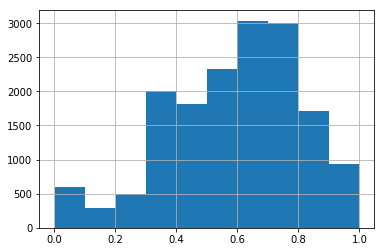

In [258]:
# The string type is not normalized
def get_hour(x):
    xint = int(x)
    hour = (xint // 100) 
    return hour

def normalize_time24h(x):
    xint = int(x)
    hour = get_hour(xint) * 60
    minute = xint % 100
    return (hour + minute) / ( 24 * 60.0)


merged['normalized_time'] =  merged['Zeit (24h)'].apply(normalize_time24h)
#Plot Distribution:
merged['normalized_time'].hist()

#Also add hour as a categorical feature.
merged['cfeature_hour'] = merged['Zeit (24h)'].apply(get_hour).astype(str)


In [259]:
#Normalize Alter as float...
merged['normalized_alter'] = merged['Alter']/100.

# Model engineering

Now its time to define our neural net model. First we pick which inputs to use for the model.

In [260]:
#Add Categorical Features
for name in merged.columns:
    if name.startswith('cfeature_'):
        categorical_to_use.add(name)
display(categorical_to_use)

for v in categorical_to_use:
    #Rewrite categorical values to Ints e.g. (maennlich = 0, weiblich =1, etc.)
    merged[v] = merged[v].astype('category').cat.as_ordered() 
    #merged[v] = merged[v].cat.codes
v= merged[TARGET_FEATURE]


{'cfeature_Bus_beteiligt',
 'cfeature_Fahranfaenger_beteiligt',
 'cfeature_Fahrrad_beteiligt',
 'cfeature_Kinder_beteiligt',
 'cfeature_Kleinbus_beteiligt',
 'cfeature_Motorrad_beteiligt',
 'cfeature_Senioren_beteiligt',
 'cfeature_Seniorfahrer_beteiligt',
 'cfeature_Taxi_beteiligt',
 'cfeature_Transporter_beteiligt',
 'cfeature_Unbekannt_beteiligt',
 'cfeature_big_lkw_beteiligt',
 'cfeature_hour',
 'cfeature_small_lkw_beteiligt',
 'cleaned_beleuchtung',
 'cleaned_beleuchtung_vorhanden',
 'cleaned_bodenbeschaffenheit',
 'cleaned_cc',
 'cleaned_day',
 'cleaned_fahrzeugtyp',
 'cleaned_geschlecht',
 'cleaned_lichtverhaeltnisse',
 'cleaned_month',
 'cleaned_strassenklasse',
 'cleaned_unfallklasse',
 'cleaned_wetterlage',
 'cleaned_wind',
 'cleaned_year',
 'cleaned_zweirad'}

In [261]:
display(merged.columns)
for name in merged.columns:
    if name.startswith('feature_'):
        continuous_to_use.add(name)
continuous_to_use.add('normalized_alter')
continuous_to_use.add('normalized_time')
display(continuous_to_use)

Index(['Alter', 'Anzahl Fahrzeuge', 'Bodenbeschaffenheit', 'DataSet_Idx',
       'Fahrzeugtyp', 'Geschlecht', 'Lichtverhältnisse', 'Strassenklasse',
       'Unfalldatum', 'Unfallklasse', 'Unfallschwere', 'Verletzte Personen',
       'Wetterlage', 'Zeit (24h)', 'is_test', 'cleaned_unfalldatum',
       'cleaned_month', 'cleaned_year', 'cleaned_day', 'cleaned_geschlecht',
       'cleaned_unfallklasse', 'cleaned_strassenklasse', 'cleaned_wind',
       'cleaned_wetterlage', 'cleaned_fahrzeugtyp', 'cleaned_cc',
       'cleaned_zweirad', 'cleaned_bodenbeschaffenheit',
       'cleaned_lichtverhaeltnisse', 'cleaned_beleuchtung',
       'cleaned_beleuchtung_vorhanden', 'groupkey', 'feature_group_size',
       'feature_average_age', 'feature_min_age', 'feature_max_age',
       'feature_anzahl_small_lkw_beteiligt',
       'feature_anzahl_big_lkw_beteiligt', 'feature_anzahl_Taxi_beteiligt',
       'feature_anzahl_Bus_beteiligt', 'feature_anzahl_Fahrrad_beteiligt',
       'feature_anzahl_Transporter

{'Anzahl Fahrzeuge',
 'Verletzte Personen',
 'feature_AnzahlFahrzeugtypen',
 'feature_Fahrer',
 'feature_Frauen',
 'feature_Fussgaenger',
 'feature_Geschlecht_Inbalance',
 'feature_Insassen',
 'feature_Maenner',
 'feature_anzahl_Bus_beteiligt',
 'feature_anzahl_Fahranfaenger_beteiligt',
 'feature_anzahl_Fahrrad_beteiligt',
 'feature_anzahl_Kinder_beteiligt',
 'feature_anzahl_Kleinbus_beteiligt',
 'feature_anzahl_Motorrad_beteiligt',
 'feature_anzahl_Senioren_beteiligt',
 'feature_anzahl_Seniorfahrer_beteiligt',
 'feature_anzahl_Taxi_beteiligt',
 'feature_anzahl_Transporter_beteiligt',
 'feature_anzahl_Unbekannt_beteiligt',
 'feature_anzahl_big_lkw_beteiligt',
 'feature_anzahl_small_lkw_beteiligt',
 'feature_average_age',
 'feature_group_size',
 'feature_max_age',
 'feature_min_age',
 'normalized_alter',
 'normalized_time'}

In [262]:
display([(c, merged[c].dtype) for c in categorical_to_use])


[('cleaned_strassenklasse',
  CategoricalDtype(categories=[0, 1, 2, 3, 4, 5], ordered=True)),
 ('cleaned_unfallklasse',
  CategoricalDtype(categories=[0, 1, 2], ordered=True)),
 ('cleaned_wetterlage',
  CategoricalDtype(categories=[0, 1, 2, 3, 4], ordered=True)),
 ('cfeature_Motorrad_beteiligt',
  CategoricalDtype(categories=[0, 1], ordered=True)),
 ('cfeature_Kleinbus_beteiligt',
  CategoricalDtype(categories=[0, 1], ordered=True)),
 ('cleaned_beleuchtung',
  CategoricalDtype(categories=[0, 1, 2, 3], ordered=True)),
 ('cfeature_Transporter_beteiligt',
  CategoricalDtype(categories=[0, 1], ordered=True)),
 ('cleaned_bodenbeschaffenheit',
  CategoricalDtype(categories=[0, 1, 2, 3, 4, 5], ordered=True)),
 ('cfeature_Fahrrad_beteiligt',
  CategoricalDtype(categories=[0, 1], ordered=True)),
 ('cleaned_lichtverhaeltnisse',
  CategoricalDtype(categories=[0, 1], ordered=True)),
 ('cleaned_geschlecht', CategoricalDtype(categories=[0, 1], ordered=True)),
 ('cleaned_year', CategoricalDtype(categ

Our Neural Net will have embeddings for categorical values.

See also: 
  - http://www.fast.ai/2018/04/29/categorical-embeddings/
  - https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12
  - https://en.wikipedia.org/wiki/Word_embedding

The following will compute the size of the embeddings (Note we cap it at 50 and at least use it by count//2 embedding colums.

In [263]:
cat_sz = [(c, len(merged[c].cat.categories)+1) for c in categorical_to_use]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
for v in categorical_to_use:
    #merged[v] = merged[v].astype('category').cat.as_ordered()
    merged[v] = merged[v].cat.codes
display(emb_szs)

[(7, 4),
 (4, 2),
 (6, 3),
 (3, 2),
 (3, 2),
 (5, 3),
 (3, 2),
 (7, 4),
 (3, 2),
 (3, 2),
 (3, 2),
 (6, 3),
 (3, 2),
 (32, 16),
 (3, 2),
 (3, 2),
 (25, 13),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (14, 7),
 (5, 3),
 (3, 2),
 (3, 2),
 (13, 7),
 (3, 2),
 (3, 2),
 (3, 2)]

Let's define a convenience class to hold our Dataset(s)

In [264]:
# A class to hold our Datasets
class TabularDataset(Dataset):
  def __init__(self, data, cat_cols=None, output_col=None):

    self.n = data.shape[0]
    if output_col is not None:
        self.y = data[output_col].astype(np.long).values #our target classification vector
    else:
        self.y = np.zeros((self.n, 1))
        
    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    return self.n

  def __getitem__(self, idx):
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

Now define a class that implements our model and the feed forward traversal through our model.

In [265]:
# A class containing the architecture of our neural net
# -> Continuous Values -\
#                        -> Linear Layer - - - - -\
#                                                  \
# Categorical Values -> Embedding Layer -> Dropout ->  (Linear Layer -> ReLU -> BatchNorm -> Dropout) -> ReLu-> SoftMax 
class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_dim, emb_dropout, lin_layer_dropouts):

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])
    
    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])
    
    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                      output_dim)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.dropout_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.dropout_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)
    
    x = F.relu(self.output_layer(x))
    x = F.softmax(x, dim=-1)
    #val, x = torch.max(x, 1)
    return x

  def freezeFirst(self,n,unfreeze=False):
    if n >= 0:
        for i,emb_layer in enumerate(self.emb_layers):
            emb_layer.requires_grad = unfreeze
        self.first_bn_layer.requires_grad = unfreeze
        self.emb_dropout_layer.requires_grad = unfreeze
    
    for i,(lin_layer, dropout_layer, bn_layer) in\
        enumerate(zip(self.lin_layers, self.dropout_layers, self.bn_layers)):
        if i+1 <= n:
            lin_layer.requires_grad = unfreeze
            dropout_layer.requires_grad = unfreeze
            bn_layer.requires_grad = unfreeze

    
    
        
        

Make sure our continous inputs are normalized

In [266]:
#Normalize Data Inputs for neural net using StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
map_f = [([n],StandardScaler()) for n in merged.columns if n in continuous_to_use]
mapper = DataFrameMapper(map_f).fit(merged)
merged[mapper.transformed_names_] = mapper.transform(merged)

Next, we partition our training data into actual training data and a validation set, that we use to estimate the accuracy of our model during training.
We must pay attention that the groupkey of training and validation set are not overlapping to avoid spillage between training/validation set.

In [267]:
TARGET_INPUT_FEATURE= 'Target_'+TARGET_FEATURE
merged[TARGET_INPUT_FEATURE] = merged[TARGET_FEATURE] - 1 #transpose by -1 to norm
training_all = merged.dropna()
test_set = merged[merged[TARGET_FEATURE].isna()]

len(training_all),len(test_set)

#It is important here that our training and validation set are distinct, i.e. the groups are completely disjunct, otherwise our validation value might be misleading as 
#the sets have group spillage and the NN might have learned group features
training_all_sorted = training_all.sort_values(by='groupkey')
#iterate over groups and sample:
training_validation_ration = 0.8

lastgroup_seen = -1,
put_into_training = False
idx_training = []
idx_validation = []
import random
for index, row in training_all_sorted.iterrows():
    if lastgroup_seen != row['groupkey']:
        lastgroup_seen = row['groupkey']

        if random.random() <= training_validation_ration:
            put_into_training = True #put it into training set
        else:
            put_into_training = False 

    if put_into_training is True:
        idx_training.append(index)
    else:
        idx_validation.append(index)
    


training_all_cols = training_all_sorted[list(continuous_to_use | categorical_to_use | set([TARGET_INPUT_FEATURE]))]
#training_all.to_feather('./training.set.df')

In [268]:
#check if partioning has worked correctly
display(len(training_all_sorted.groupkey.unique()))
display(len(training_all_sorted.loc[idx_training].groupkey.unique())+len(training_all_sorted.loc[idx_validation].groupkey.unique()))

11195

11195

In [269]:

#trainval_cutoff_idx = int(training_validation_ration*len(training_all_cols))
#training_slice = training_all_cols.iloc[:trainval_cutoff_idx].reset_index(drop=True)
#validation_slice = training_all_cols.iloc[trainval_cutoff_idx:].reset_index(drop=True)

training_slice = training_all_cols.loc[idx_training]
validation_slice = training_all_cols.loc[idx_validation]

# In development of this model, we tried overdsampling, however, results were quite bad. each time!

"""#over-sampling using balanced weights...
##val_weights = (1 - training_slice['Target_Unfallschwere'].value_counts().values/training_slice['Target_Unfallschwere'].value_counts().values.sum())/len(training_slice)
val_weights = (1/training_slice['Target_Unfallschwere'].value_counts().values/training_slice['Target_Unfallschwere'].value_counts().values.sum())
display(val_weights)
sampling_weights = [val_weights[x] for x in training_slice['Target_Unfallschwere'].astype(int).values]
##sampling_weights = (training_slice['Target_Unfallschwere'] + 1) / ((training_slice['Target_Unfallschwere'] + 1).values.sum())
training_sampler = torch.utils.data.sampler.WeightedRandomSampler(sampling_weights,len(training_slice))
"""

"""#over-sampling using SMOTE
import pandas_ml as pdml
#sm = SMOTE(random_state=12, ratio = 1.0)
training_pdml_slice = pdml.ModelFrame(data=training_slice.drop('Target_Unfallschwere',axis=1,inplace=False),target=training_slice['Target_Unfallschwere'])
sampler = training_pdml_slice.imbalance.over_sampling.SMOTE(ratio=1.0,random_state=12)
#sampler = training_pdml_slice.imbalance.under_sampling.ClusterCentroids()
sampled = training_pdml_slice.fit_sample(sampler)
#x_res, y_res = sm.fit_sample(training_slice,training_slice['Target_Unfallschwere'],)
"""


# Oversample training set slightly...
max_size = training_slice[TARGET_INPUT_FEATURE].value_counts().max()
lst = [training_slice]
for class_index, group in training_slice.groupby(TARGET_INPUT_FEATURE):
    lst.append(group.sample(frac=1-len(group)/max_size, replace=True))
sampled = pd.concat(lst)


training_dataset = TabularDataset( sampled, cat_cols=list(categorical_to_use), output_col=TARGET_INPUT_FEATURE)
validation_dataset = TabularDataset( validation_slice, cat_cols=list(categorical_to_use), output_col=TARGET_INPUT_FEATURE)
#trainval_cutoff_idx, len(training_slice), len(sampling_weights)

In [270]:
max_size

10824

In [271]:
display(len(training_slice[training_slice[TARGET_INPUT_FEATURE] == .0]))
display(len(training_slice[training_slice[TARGET_INPUT_FEATURE] == 1.0]))
display(len(training_slice[training_slice[TARGET_INPUT_FEATURE] == 2.0]))

display(len(sampled[sampled[TARGET_INPUT_FEATURE] == .0]))
display(len(sampled[sampled[TARGET_INPUT_FEATURE] == 1.0]))
display(len(sampled[sampled[TARGET_INPUT_FEATURE] == 2.0]))


10824

1307

95

10824

2456

189

# Training our NeuralNet

In [272]:
BATCH_SIZE = 256 #How many datapoints do we adjust the model at once? 

In [273]:
dataloader = DataLoader(training_dataset, BATCH_SIZE, num_workers=0, shuffle=True)
vdataloader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False, num_workers=0) # no sampling for testing

In [274]:
#USE GPU for training if available (much faster train times)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [285]:
NO_OF_EPOCS = 500 # How many iterations through training data?
FREEZE_AFTER = NO_OF_EPOCS//3 #Fine Tune last layers (firsy layers frozen)

lin_layers = [1024,2048,2048,1024,1024,512,128] #first layer is for cont variables only!
dropout_p = [2.0/x for x in lin_layers] # 2% for each dropout each layer
model = FeedForwardNN(emb_szs, no_of_cont=len(continuous_to_use), lin_layer_sizes=lin_layers,
                          output_dim=3, emb_dropout=0.04,
                          lin_layer_dropouts=dropout_p).to(device)

# Tested Alternative  Architectures: 
# 0,97% training, .95% acc
#model = FeedForwardNN(emb_szs, no_of_cont=len(continuous_to_use), lin_layer_sizes=[1000,500,250,100,100],
#                          output_dim=3, emb_dropout=0.04,
#                          lin_layer_dropouts=[0.001,0.002,0.00125,0.05,0.05]).to(device)
# 0.97% training, 95% acc
#model = FeedForwardNN(emb_szs, no_of_cont=len(continuous_to_use), lin_layer_sizes=[1000,1000,1000,100],
#                          output_dim=3, emb_dropout=0.04,
#                          lin_layer_dropouts=[0.001,0.001,0.001,0.01]).to(device)
# 0.98 training 95 acc


#val_weights = (training_slice['Target_Unfallschwere'].value_counts().values/training_slice['Target_Unfallschwere'].value_counts().values.sum())

criterion = nn.CrossEntropyLoss(torch.tensor([0.06,0.27,0.67])) #Instead of oversampling use weighted loss function!
#criterion = nn.NLLLoss()
#criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()



In [286]:
losses = {'train': [], 'val': []}
acc = {'train': [], 'val': []}
best_model = model
best_acc = 0.0

In [287]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#Other optimizers/schedulers tested:
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters())

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=20, eta_min=1e-10, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

logger = logging.getLogger()
logger.handlers = [] #idempotence for jupyter
hdlr = logging.FileHandler('./training.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
hdlr.setLevel(logging.DEBUG)
ch = logging.StreamHandler(stream=sys.stdout)
ch.setLevel(logging.INFO)
logger.addHandler(hdlr)
logger.addHandler(ch) 
logger.setLevel(logging.DEBUG)
logger.debug("Training started...")

#unfreeze all layers
model.freezeFirst(len(lin_layers),unfreeze=True)

dset_loaders = {
    'train':dataloader,
    'val':vdataloader
}
dataset_sizes = {'train':float(len(training_dataset)),
                'val': float(len(validation_dataset))
                }

for epoch in range(NO_OF_EPOCS):
    logger.debug('Epoch {}/{}'.format(epoch, NO_OF_EPOCS))
    logger.debug('-' * 10)
    if epoch == FREEZE_AFTER:
        model.freezeFirst(len(lin_layers)-3,unfreeze=False) 
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        wrong_preds = Counter()
        correct_preds = Counter()
        
        # Iterate over data batches:
        for y, cont_x, cat_x in dset_loaders[phase]:
            cat_x = cat_x.to(device)
            cont_x = cont_x.to(device)
            y  = y.to(device)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(cont_x, cat_x)
            _, preds = torch.max(outputs, 1)

            #print(outputs,y)
            loss = criterion(outputs, y)
            for y_pred, y_target in zip(preds,y):
                if y_pred != y_target:
                    wrong_preds[int(y_target)]+=1
                else:
                    correct_preds[int(y_target)]+=1

            # backward propagation + optimizer call only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()
                scheduler.step()

            # statistics
            running_loss += loss.item() * cont_x.size(0)
            #running_corrects += torch.sum(preds == labels.data)
            running_corrects += torch.sum(preds == y.data)
            
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        losses[phase].append(epoch_loss)
        acc[phase].append(epoch_acc)

        logger.debug('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        logger.debug('  Correct: {}'.format(correct_preds.most_common()))
        logger.debug('  Wrong: {}'.format(wrong_preds.most_common()))
        
        
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            logger.info("Epoch {}, New Best Model found: Acc {:.4f}".format(epoch,epoch_acc))
            best_acc = epoch_acc
            best_model = copy.deepcopy(model)


print('Best val Acc: {:4f}'.format(best_acc))

Epoch 0, New Best Model found: Acc 0.6127
Epoch 3, New Best Model found: Acc 0.6424
Epoch 4, New Best Model found: Acc 0.6444
Epoch 5, New Best Model found: Acc 0.6771
Epoch 7, New Best Model found: Acc 0.6861
Epoch 8, New Best Model found: Acc 0.7112
Epoch 10, New Best Model found: Acc 0.7202
Epoch 12, New Best Model found: Acc 0.7409
Epoch 14, New Best Model found: Acc 0.7506
Epoch 15, New Best Model found: Acc 0.7509
Epoch 16, New Best Model found: Acc 0.7523
Epoch 17, New Best Model found: Acc 0.7656
Epoch 19, New Best Model found: Acc 0.7699
Epoch 20, New Best Model found: Acc 0.7763
Epoch 23, New Best Model found: Acc 0.7780
Epoch 26, New Best Model found: Acc 0.7940
Epoch 31, New Best Model found: Acc 0.8020
Epoch 38, New Best Model found: Acc 0.8070
Epoch 47, New Best Model found: Acc 0.8077
Epoch 48, New Best Model found: Acc 0.8093
Epoch 51, New Best Model found: Acc 0.8100
Epoch 55, New Best Model found: Acc 0.8204
Epoch 69, New Best Model found: Acc 0.8254
Epoch 111, New Be

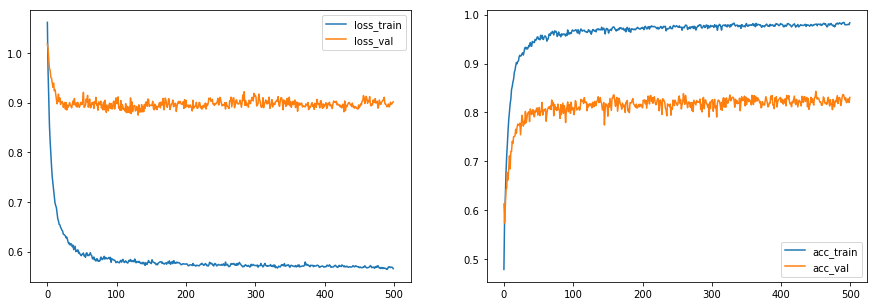

In [289]:
%matplotlib inline
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
for part in losses.keys():
    ax[0].plot(losses[part],label='loss_'+part)
    ax[0].legend()

for part in acc.keys():
    ax[1].plot(acc[part],label='acc_'+part)
    ax[1].legend()


We see even beyond epochs there is little overfitting as the validation set. However, accuracy plateaus at 87% early on.

In [294]:
#save our model
#this enables us to reuse the trained model later-on using torch.load()
torch.save(best_model, 'neural-net.torch')


/home/bewo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FeedForwardNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Classify Test Data

Finally, we will use our model to classify the test data provided with this challenge.

In [295]:
test_all_cols = test_set[list(continuous_to_use | categorical_to_use)]
test_dataset = TabularDataset( test_all_cols, cat_cols=list(categorical_to_use), output_col=None)
test_dataloader = DataLoader(test_dataset, 1, num_workers=0, shuffle=False)
output_df = pd.DataFrame(columns=['Unfall_ID','Unfallschwere'])
model.train(False)
for idx, (_, cont_x, cat_x) in enumerate(test_dataloader):
    outputs = model(cont_x, cat_x)
    _, pred = torch.max(outputs, 1)
    #We transformed predictions by 
    output_df.loc[idx] = [test_set.iloc[idx].DataSet_Idx,int(pred) + 1]


In [296]:
dfs = DataFrameSummary(output_df)
dfs.columns_stats.T

,counts,uniques,missing,missing_perc,types
Unfall_ID,1000,1000,0,0%,unique
Unfallschwere,1000,3,0,0%,categorical


And export it to the target CSV format...

In [297]:
output_df.to_csv('./output/classified-testdata.csv',index=False)